In [1]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
split=['train[:10%]', "train[10%:25%]", "train[25%:]"], as_supervised=True,
with_info=True)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\wiech\tensorflow_datasets\tf_flowers\incomplete.W7ZOO0_3.0.1\tf_flowers-train.tfrecord*...:…

Dataset tf_flowers downloaded and prepared to C:\Users\wiech\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [3]:
from keras_tuner.src.backend.io import tf

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

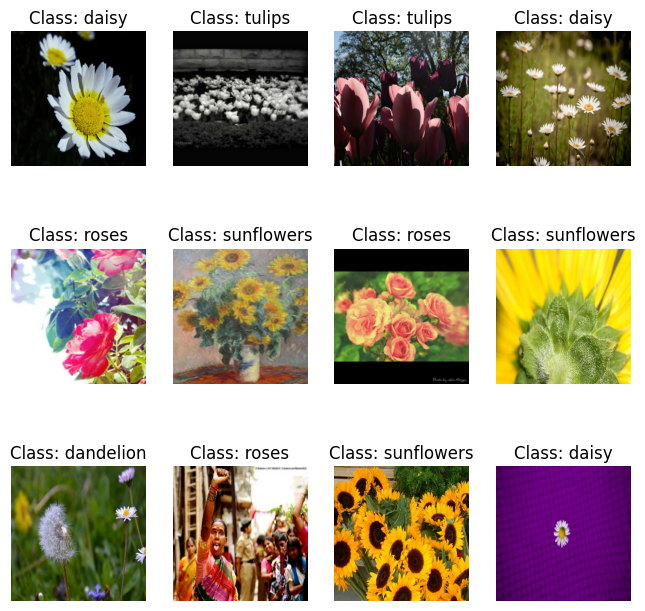

In [4]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch: 
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

model = Sequential([
    Rescaling(1./255),
    Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [7]:
import pickle
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set, epochs=10, validation_data=valid_set)
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)
    
model.save('simple_cnn_flowers.keras')

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 697ms/step - accuracy: 0.3198 - loss: 1.8631 - val_accuracy: 0.5082 - val_loss: 1.2996
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 635ms/step - accuracy: 0.5493 - loss: 1.1531 - val_accuracy: 0.5535 - val_loss: 1.1046
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 629ms/step - accuracy: 0.6561 - loss: 0.9085 - val_accuracy: 0.6080 - val_loss: 1.0446
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 631ms/step - accuracy: 0.8024 - loss: 0.5699 - val_accuracy: 0.5481 - val_loss: 1.2950
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 634ms/step - accuracy: 0.9159 - loss: 0.2703 - val_accuracy: 0.5808 - val_loss: 1.6186
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 630ms/step - accuracy: 0.9630 - loss: 0.1166 - val_accuracy: 0.5717 - val_loss: 1.9476
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 58s 670ms/step - accuracy: 0.9872 - loss: 0.0583 - val_accuracy: 0.5590 - val_loss: 2.4018
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 56s 646ms/step - accuracy: 0.9900 - loss: 0.0787 - val_accu

In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image) 
    return final_image, label

base_model = tf.keras.applications.xception.Xception( weights="imagenet",
include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(n_classes, activation='softmax')(avg)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

for layer in base_model.layers:
    layer.trainable = True

history = model.fit(train_set, epochs=3, validation_data=valid_set)

acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

with open('xception_acc.pkl', 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)
    
model.save("xception_flowers.keras")

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.2644 - loss: 6.0477 - val_accuracy: 0.3739 - val_loss: 2.8804
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4217 - loss: 2.6600 - val_accuracy: 0.4065 - val_loss: 2.6262
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.4701 - loss: 2.1580 - val_accuracy: 0.4519 - val_loss: 2.6917
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5188 - loss: 1.9811 - val_accuracy: 0.4701 - val_loss: 2.7679
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5836 - loss: 1.6166 - val_accuracy: 0.4574 - val_loss: 2.0681
Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.5986 - loss: 1.3576 - val_accuracy: 0.4682 - val_loss: 2.2636
Epoch 2/3
 7/86 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.6273 - loss: 1.3734